0.6328384876251221
0.625687837600708
0.8160243034362793
0.6291637420654297
0.8262245655059814
0.8038749694824219
0.9168117046356201
1.0170490741729736
0.7342114448547363
1.0366723537445068
0.7147438526153564
0.7169427871704102
0.7556326389312744
0.665438175201416
0.7240376472473145
0.6663331985473633
0.721574068069458
0.8775160312652588
0.6917908191680908
0.8147068023681641
0.815570592880249
0.8362128734588623
0.8548400402069092
0.8394927978515625
0.894984245300293
0.8497219085693359
0.8185126781463623
0.8072500228881836
0.8445067405700684
0.8676025867462158
0.8190350532531738
0.8222379684448242
0.8369042873382568
0.8621795177459717
0.8262271881103516
0.8138236999511719
0.8149628639221191
0.8215434551239014
0.8173446655273438
0.8399653434753418
0.8344194889068604
0.8236351013183594
0.8274705410003662
0.8267440795898438
0.7485268115997314
0.7280995845794678
0.7988958358764648
0.8978888988494873
0.7821822166442871
1.0057990550994873
0.7487835884094238
0.7028517723083496
0.749282598495483

C:\Users\sa\AppData\Local\Temp\ipykernel_4928\202144985.py:209: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animate = matplotlib.animation.FuncAnimation(fig, nextFrame, interval=1, blit=True)


0.7029609680175781
0.7448813915252686
0.7655284404754639
0.8530609607696533
0.7320189476013184
0.7211649417877197
0.7999477386474609
0.8711798191070557
0.8182454109191895
0.8613801002502441
0.8328232765197754
0.8199524879455566
0.8345167636871338
0.8160183429718018
0.8111832141876221
0.8150532245635986
0.8450164794921875
0.8387584686279297
0.8310949802398682
0.8341150283813477
0.7718393802642822
0.8102662563323975
0.7939703464508057
0.846311092376709
0.8121199607849121
0.8208739757537842
0.818359375
0.8437240123748779
0.8559219837188721
0.8322792053222656
0.7953462600708008
0.816319465637207
0.8004333972930908
0.7977018356323242
0.7699429988861084
0.696840763092041
0.8886017799377441
0.7379879951477051
0.7109622955322266
0.8218123912811279
0.8900129795074463
0.6578912734985352
0.7336416244506836
0.7358818054199219
0.6972537040710449
0.6937880516052246
0.6978530883789062
0.6635961532592773
0.6515228748321533
0.7650449275970459
0.7787175178527832
0.7871158123016357
0.8147180080413818
0.7

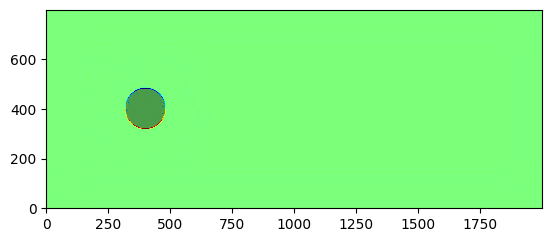

In [1]:
import time
import matplotlib.pyplot as plt, matplotlib.animation
import numpy as np
import numba as nb

""" Зададим константы и свойства задачи """

Viscosity = 0.01                                # вязкость жидкости
Height, Width = 10 * 80, 10 * 200                          # размеры решетки

U0 = np.array([0.10, 0])                        # начальная и внешняя скорость (в махах)

Ux  = np.zeros((Height, Width)) + U0[0]
Uy  = np.zeros((Height, Width)) + U0[1]
Rho = np.ones((Height, Width))

Ux0  = np.zeros((Height, Width)) + U0[0]
Uy0  = np.zeros((Height, Width)) + U0[1]
Rho0 = np.ones((Height, Width))

def BarrierShape():
    """ Инициализируем форму барьера. Необходимо установить True там, где барьер """
    barrier = np.zeros((Height, Width), bool)

    # круг
    for y in range(barrier.shape[0]):
        for x in range(barrier.shape[1]):
            if (y - Height//2)**2 + (x - Height//2)**2 < (Height//10)**2:
                barrier[y,x] = True
    # хвост
    # barrier[(Height//2), ((Height//2)):((Height//2)+4*(Height//10))] = True

    return barrier


""" Зададим свойства шаблона решетки D2Q9 """

D = 2 # Мерность модели
Q = 9 # число точек в шаблоне

V = np.array([
    [-1, 1],[ 0, 1],[ 1, 1],
    [-1, 0],[ 0, 0],[ 1, 0],
    [-1,-1],[ 0,-1],[ 1,-1]
])

W = np.array([
    1/36, 1/9, 1/36,
    1/9,  4/9, 1/9,
    1/36, 1/9, 1/36
])

C = 1/3**0.5  # Скорость звука в модели


def InitBarrier():
    """ Создаем барьер и отталкивающие границы барьера """
    barrierC = BarrierShape()

    barrierN = np.roll(barrierC,  1, axis=0)
    barrierS = np.roll(barrierC, -1, axis=0)
    barrierE = np.roll(barrierC,  1, axis=1)
    barrierW = np.roll(barrierC, -1, axis=1)
    barrierNE = np.roll(barrierN,  1, axis=1)
    barrierNW = np.roll(barrierN, -1, axis=1)
    barrierSE = np.roll(barrierS,  1, axis=1)
    barrierSW = np.roll(barrierS, -1, axis=1)

    return np.array([
        barrierNW, barrierN, barrierNE,
        barrierW,  barrierC, barrierE,
        barrierSW, barrierS, barrierSE
    ])


def F_stat(Ux, Uy, Rho):
    """ Вычисляем статистическое распределение частиц в зависимости от общей скорости и плотности """
    UV = np.zeros((Q, Height, Width)) 
    for q in range(Q):
        UV[q] = (V[q,0]*Ux + V[q,1]*Uy)/C**2

    U2 = (Ux**2 + Uy**2)/C**2

    f_stat = np.zeros((Q, Height, Width))
    for q in range(Q):
        f_stat[q] = Rho * W[q] * (1 + UV[q] + UV[q]**2/2 - U2/2)

    return f_stat

def Mode0(f):
    """ Плотность """
    mode = np.zeros((Height, Width))
    for q in range(Q):
        mode += f[q]
    return mode

def Mode1(f):
    """ Плотность*Скорость """
    mode = np.zeros((D, Height, Width))
    for q in range(Q):
        for d1 in range(D):
            mode[d1] += f[q]*V[q,d1]
    return mode

def Mode2(f):
    """ Плотность*[Скорость x Скорость] минус тензор напряжения """
    mode = np.zeros((D,D,Height, Width))
    for q in range(Q):
        for d1 in range(D):
            for d2 in range(D):
                mode[d1,d2] += f[q]*V[q,d1]*V[q,d2]
    return mode


def iter(f, f_out, barrier):
    """stream"""
    now = time.time()

    (fNW, fN, fNE, fW, fC, fE, fSW, fS, fSE) = f

    for y in range(Height-1,0,-1):
        fN[y]  = fN[y-1]
        fNE[y] = fNE[y-1]
        fNW[y] = fNW[y-1]

    fS[:-1]  = fS[1:]
    fSE[:-1] = fSE[1:]
    fSW[:-1] = fSW[1:]

    fE[:,1:]  = fE[:,:-1]
    fNE[:,1:] = fNE[:,:-1]
    fSE[:,1:] = fSE[:,:-1]

    fW[:,:-1]  = fW[:,1:]
    fNW[:,:-1] = fNW[:,1:]
    fSW[:,:-1] = fSW[:,1:]

    """ BC_barrier """
    (bNW, bN, bNE, bW, bC, bE, bSW, bS, bSE) = barrier

    fN[bN]   = fS[bC]
    fS[bS]   = fN[bC]
    fE[bE]   = fW[bC]
    fW[bW]   = fE[bC]
    fNE[bNE] = fSW[bC]
    fNW[bNW] = fSE[bC]
    fSE[bSE] = fNW[bC]
    fSW[bSW] = fNE[bC]

    """ Calc U, Rho """
    Rho = Mode0(f)

    Ux, Uy = Mode1(f)
    Ux /= Rho
    Uy /= Rho

    """ Collide """

    f += (F_stat(Ux, Uy, Rho)-f)/(0.5 + Viscosity/C**2)

    """ BC_out """

    f[:,0,:] = f_out[:,0,:]
    f[:,-1,:] = f_out[:,-1,:]
    f[:,:,0] = f_out[:,:,0]
    f[:,:,-1] = f_out[:,:,-1]
    print(time.time()-now)

def curl(ux, uy):
    """ двумерный ротор макроскопического поля скорости """ 
    return np.roll(uy,-1,axis=1) - np.roll(uy,1,axis=1) - np.roll(ux,-1,axis=0) + np.roll(ux,1,axis=0)

def main():

    barrier = InitBarrier()

    F = F_stat(Ux, Uy, Rho)

    F_out = F_stat(Ux, Uy, Rho)

    for _ in range(100):
        iter(F, F_out, barrier)

    fig, ax = plt.subplots()

    fluidImage = ax.imshow(curl(Ux, Uy), origin='lower', norm=plt.Normalize(-.1,.1), 
                                        cmap=plt.get_cmap('jet'), interpolation='none')

    bImageArray = np.zeros((Height, Width, 4), np.uint8)
    bImageArray[barrier[4],3] = 100
    barrierImage = plt.imshow(bImageArray, origin='lower', interpolation='none')


    def nextFrame(_):

        for _ in range(40):
            iter(F, F_out, barrier)

        Rho = Mode0(F)
        Ux, Uy = Mode1(F)

        # E = Mode2(F)
        Ux /= Rho
        Uy /= Rho

        fluidImage.set_array(curl(Ux, Uy))
        return (fluidImage, barrierImage)        

    animate = matplotlib.animation.FuncAnimation(fig, nextFrame, interval=1, blit=True)
    plt.show()



if __name__ == '__main__':
    main()